In [124]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import pytesseract
from shapely import LineString, Point, Polygon, box

# Importar datos desde csv

In [125]:
data_segmentos = '../01_ingest_labeled_data/output_csv/data_segments.csv'
data_imagenes = '../01_ingest_labeled_data/output_csv/data_images.csv'
df_segmentos = pd.read_csv(data_segmentos).drop(columns=['Unnamed: 0'])
df_imagenes = pd.read_csv(data_imagenes).drop(columns=['Unnamed: 0'])

In [126]:
df_segmentos.head()

,file,x_1,y_1,x_2,y_2,label,content
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender..."


In [127]:
df_imagenes.head()

,file,bitmap,height,width
0,La Voz 1985-06-26 Otra sesión sobre....tif,[[[255 255 255]\n [255 255 255]\n [255 255 2...,4329.0,3231.0
1,Crónica 1983-12-14 General Weher Justifico tod...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,971.0,1672.0
2,La Razon 1986-12-05 Los senadores de la Renova...,[[[0 0 0]\n [0 0 0]\n [0 0 0]\n ...\n [0 0...,1009.0,1202.0
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,[[[255 255 255]\n [255 255 255]\n [255 255 2...,252.0,945.0


## Procesamiento de un artículo puntual

In [129]:
articulo = df_imagenes.iloc[0]
articulo

file             La Voz 1985-06-26 Otra sesión sobre....tif
bitmap    [[[255 255 255]\n  [255 255 255]\n  [255 255 2...
height                                               4329.0
width                                                3231.0
Name: 0, dtype: object

In [130]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']]
segmentos_articulo

,file,x_1,y_1,x_2,y_2,label,content
9,La Voz 1985-06-26 Otra sesión sobre....tif,2863,142,3070,200,Diario,LA VOZ
10,La Voz 1985-06-26 Otra sesión sobre....tif,90,142,704,200,Fecha,Miércoles 26 de junio de 1985
11,La Voz 1985-06-26 Otra sesión sobre....tif,1163,271,3179,626,Título,Otra sesión sobree la\nrepresión en Córdoba
12,La Voz 1985-06-26 Otra sesión sobre....tif,1248,649,2147,1017,Copete,"El secuestro de René Salamanca, secretario\nge..."
13,La Voz 1985-06-26 Otra sesión sobre....tif,1124,1021,1622,2274,Cuerpo,Los casos de las desapariciones\ndel sindicali...
14,La Voz 1985-06-26 Otra sesión sobre....tif,1654,1027,2145,2274,Cuerpo,"secuestrada en ""La\nPerla"" y que para legaliza..."
15,La Voz 1985-06-26 Otra sesión sobre....tif,2178,1557,2663,2281,Cuerpo,"su suegro, Miguel Angel Soria,\nlos trámites r..."
16,La Voz 1985-06-26 Otra sesión sobre....tif,2688,1557,3179,2281,Cuerpo,"del pago, ""tengo entendido\nque cubrió ese res..."
17,La Voz 1985-06-26 Otra sesión sobre....tif,2178,678,3193,1486,Fotografía,NaN
18,La Voz 1985-06-26 Otra sesión sobre....tif,2173,1491,3174,1527,Epígrafe,EI coronel Genta sabía de un rescate pagado en...


# Obtener tokens

In [131]:
path_images = '../01_ingest_labeled_data/iaxidentidad_tif'

In [132]:
mi_cfg = r"-l spa --psm 3 --oem 3"

In [134]:
df_tokens = pytesseract.image_to_data(path_images + '/' + articulo['file'], config=mi_cfg, output_type=pytesseract.Output.DATAFRAME)

In [135]:
df_tokens.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2573 entries, 0 to 2572
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   level      2573 non-null   int64  
 1   page_num   2573 non-null   int64  
 2   block_num  2573 non-null   int64  
 3   par_num    2573 non-null   int64  
 4   line_num   2573 non-null   int64  
 5   word_num   2573 non-null   int64  
 6   left       2573 non-null   int64  
 7   top        2573 non-null   int64  
 8   width      2573 non-null   int64  
 9   height     2573 non-null   int64  
 10  conf       2573 non-null   float64
 11  text       2032 non-null   object 
dtypes: float64(1), int64(10), object(1)
memory usage: 241.3+ KB


## Limpieza

In [156]:
def confidence_filter(df_data, confianza_min):
    """Devuelve df con palabras que superan X umbral de confianza en la detección. Parámetros: df original y confianza mínima."""
    mask_conf = (df_data['conf'].astype('float') > confianza_min)
    print('Eliminados ', df_data[~mask_conf].shape[0])
    #print(df_data[~mask_conf])
    return df_data[mask_conf]

def blank_filter(df_data):
    """Devuelve df sin elementos que fueron detectados como espacios. Parámetro: df original."""    
    mask_not_blank = (df_data['text'].str.strip() != '') & (df_data['text'] != np.NaN)
    print('Eliminados ', df_data[~mask_not_blank].shape[0])
    #print(df_data[~mask_not_blank])
    return df_data[mask_not_blank]

def height_filter(df_data):
    """Devuelve df sin outliers detectados en función de la altura del elemento. Parámetro: df original."""    
    highThresh_h = round(df_data['height'].quantile(.90) * 6)
    lowThresh_h = round(df_data['height'].quantile(.90) / 5)
    mask_height = (df_data['height'] > lowThresh_h) & (df_data['height'] < highThresh_h)
    print('Eliminados ', df_data[~mask_height].shape[0])
    #print(df_data[~mask_height])
    return df_data[mask_height]

In [157]:
df_tokens = confidence_filter(df_tokens, 20)

Eliminados  0


In [158]:
df_tokens = blank_filter(df_tokens)

Eliminados  0


## Generar poligonos de bounding boxes a partir de coordenadas

In [139]:
df_tokens['poligono'] = df_tokens.apply(lambda row: box(row.left, row.top, row.left + row.width, row.top + row.height), axis=1)
df_tokens

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text,poligono
16,5,1,4,1,1,1,79,153,17,16,67.238327,*,"POLYGON ((96 153, 96 169, 79 169, 79 153, 96 1..."
17,5,1,4,1,1,2,116,145,182,33,96.616508,Miércoles,"POLYGON ((298 145, 298 178, 116 178, 116 145, ..."
18,5,1,4,1,1,3,311,150,44,31,96.767792,26,"POLYGON ((355 150, 355 181, 311 181, 311 150, ..."
19,5,1,4,1,1,4,374,149,43,31,96.986313,de,"POLYGON ((417 149, 417 180, 374 180, 374 149, ..."
20,5,1,4,1,1,5,431,150,91,38,96.847931,junio,"POLYGON ((522 150, 522 188, 431 188, 431 150, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2567,5,1,69,1,6,8,3192,4221,3,1,39.232903,”,"POLYGON ((3195 4221, 3195 4222, 3192 4222, 319..."
2569,5,1,69,1,7,1,2692,4256,107,26,96.625610,trámite,"POLYGON ((2799 4256, 2799 4282, 2692 4282, 269..."
2570,5,1,69,1,7,2,2810,4256,38,26,80.815750,de,"POLYGON ((2848 4256, 2848 4282, 2810 4282, 281..."
2571,5,1,69,1,7,3,2858,4260,63,23,80.815750,esta,"POLYGON ((2921 4260, 2921 4283, 2858 4283, 285..."


In [140]:
df_segmentos['poligono'] = df_segmentos.apply(lambda row: box(row.x_1, row.y_1, row.x_2, row.y_2), axis=1)
df_segmentos

,file,x_1,y_1,x_2,y_2,label,content,poligono
0,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,12,19,863,78,Título,AROSA DESCARTO UN GOLPE MILITAR,"POLYGON ((863 19, 863 78, 12 78, 12 19, 863 19))"
1,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,642,144,761,159,Destacado,HABLA TROCCOLI,"POLYGON ((761 144, 761 159, 642 159, 642 144, ..."
2,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,14,92,309,229,Cuerpo,La eventualidad de un golpe militar fue descar...,"POLYGON ((309 92, 309 229, 14 229, 14 92, 309 ..."
3,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,323,90,623,228,Cuerpo,"de servir a una causa justa, al extenderse en ...","POLYGON ((623 90, 623 228, 323 228, 323 90, 62..."
4,La Gaceta de hoy 1986-12-24 Arosa descartó un ...,641,90,932,142,Cuerpo,"la calificó como ""muy discutible"" por entender...","POLYGON ((932 90, 932 142, 641 142, 641 90, 93..."
...,...,...,...,...,...,...,...,...
201,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,95,417,419,894,Cuerpo,El doctor Julio Desiderio\nBurlando a cargo de...,"POLYGON ((419 417, 419 894, 95 894, 95 417, 41..."
202,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,446,417,764,892,Cuerpo,privación ilegítima de libertad\ny violación d...,"POLYGON ((764 417, 764 892, 446 892, 446 417, ..."
203,Tiempo Argentino 1985-11-14 Sobreseimiento a m...,796,417,1122,892,Cuerpo,"Plata, y no lo habría denunciado\n.\nEl magist...","POLYGON ((1122 417, 1122 892, 796 892, 796 417..."
204,Tiempo Argentino 1986-01-10 Querella del ex......,71,9,640,146,Título,"Querella del ex oficial\nHours por ""injurias""","POLYGON ((640 9, 640 146, 71 146, 71 9, 640 9))"


In [141]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']][['poligono', 'label']]

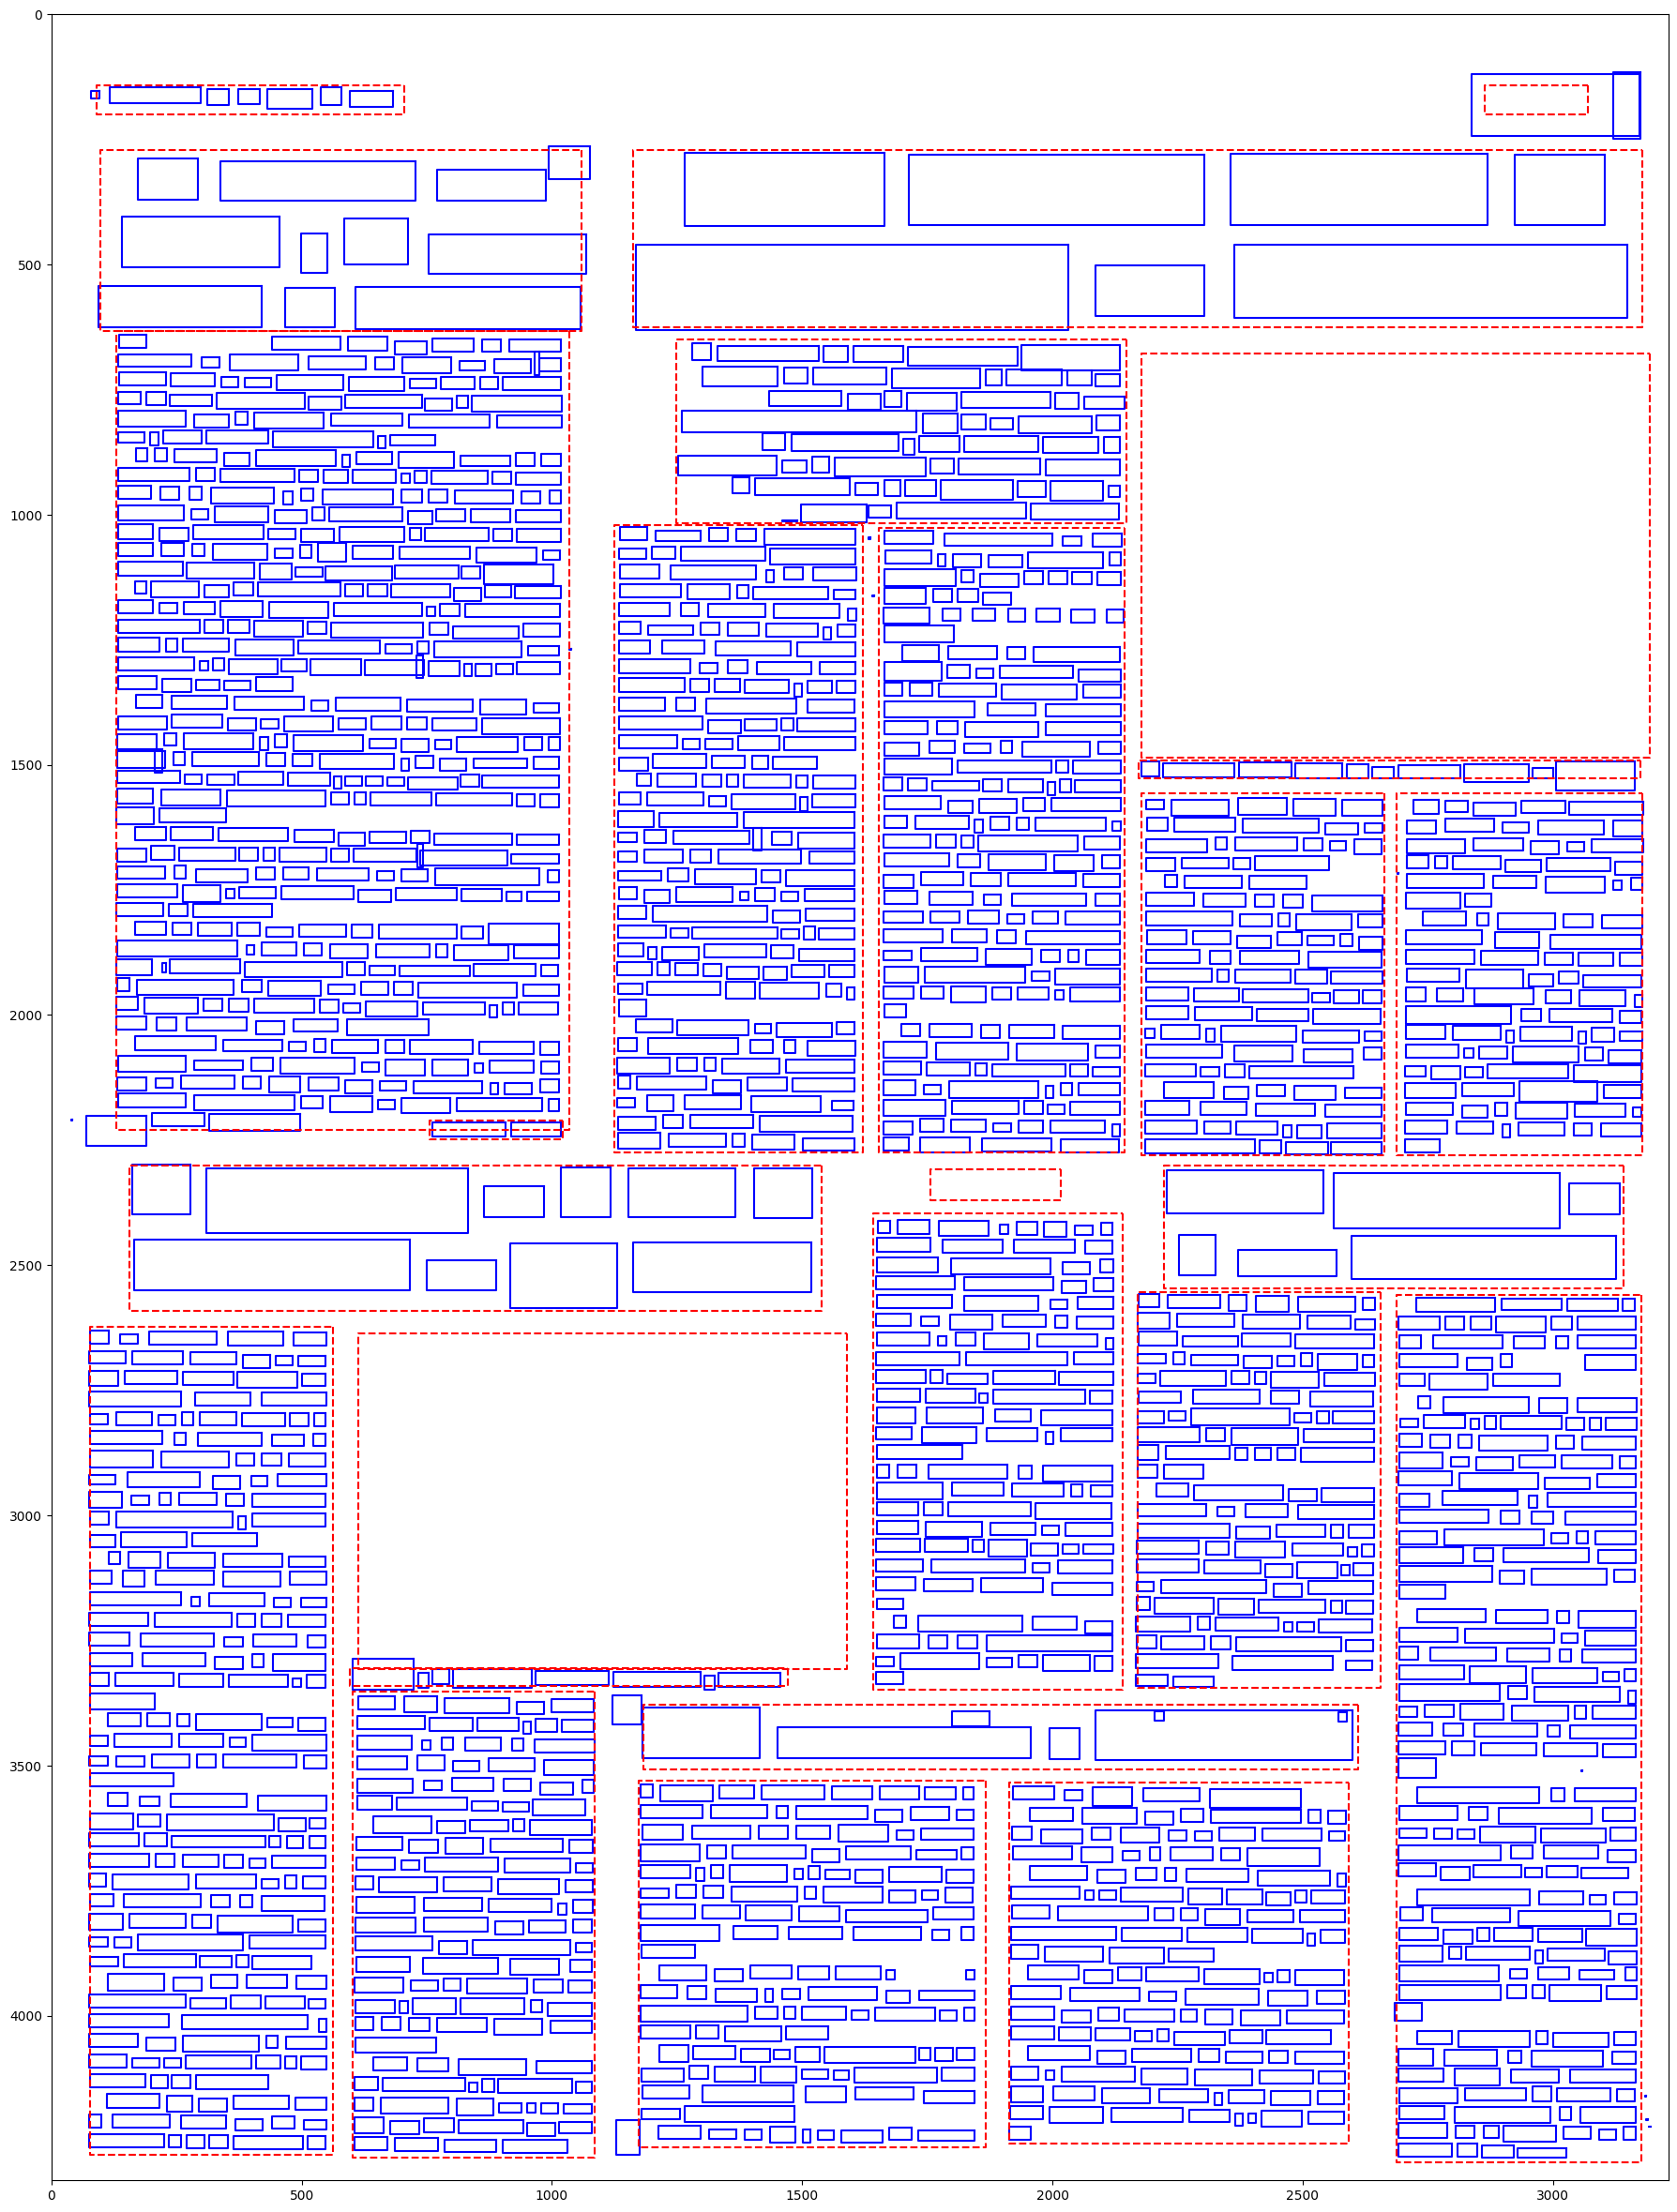

In [142]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for r in df_tokens['poligono']:
    r_coords = list(r.exterior.coords)

    ax.plot(*zip(*r_coords), color='b')

for r in segmentos_articulo['poligono']:
    r_coords = list(r.exterior.coords)

    ax.plot(*zip(*r_coords), color='r', linestyle='--')
    
plt.axis([0, articulo['width'], articulo['height'], 0])
plt.show()

## Obtener etiqueta de tokens a partir de etiquetado manual

In [143]:
def get_label_token(poligono_token, segmentos_articulo):
    #segmentos_articulo = df_segmentos[df_segmentos['file']==file][['poligono', 'label']]
    #print(segmentos_articulo.shape)
    #etiqueta = np.nan
    label_candidates = {'etiqueta': -1, 'perc': -1}
    i=0
    for _, segmento in segmentos_articulo.iterrows():
        #print('Poligono token: ')
        #display(poligono_token)
        #print('Poligono segmento: ')
        #display(_, segmento['poligono'])
        if poligono_token.intersects(segmento['poligono']):
            i+=1
            perc = poligono_token.intersection(segmento['poligono']).area
            #print ('(label_candidates[perc]', label_candidates['perc'])
            #print('new perc', perc)
            if (label_candidates['perc'] < perc):
                label_candidates = {'etiqueta': segmento['label'], 'perc': perc}
                #print(i)
    
    return label_candidates['etiqueta']

In [144]:
segmentos_articulo = df_segmentos[df_segmentos['file']==articulo['file']][['poligono', 'label']]
df_tokens['label'] = df_tokens['poligono'].apply(lambda x: get_label_token(x, segmentos_articulo))

## Debug

In [146]:
import matplotlib.colors as mcolors

In [151]:
colores = list(mcolors.TABLEAU_COLORS.values())
colores.append('#ff0000')
colores.append('#00ff00')
colores

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf',
 '#ff0000',
 '#00ff00']

In [152]:
partes = ['Diario', 'Fecha', 'Volanta', 'Copete', 'Destacado', 'Título', 'Cuerpo', 'Fotografía', 'Epígrafe', 'Firma', 'Página', '-1']

In [153]:
color_dict = dict(zip(partes,colores))

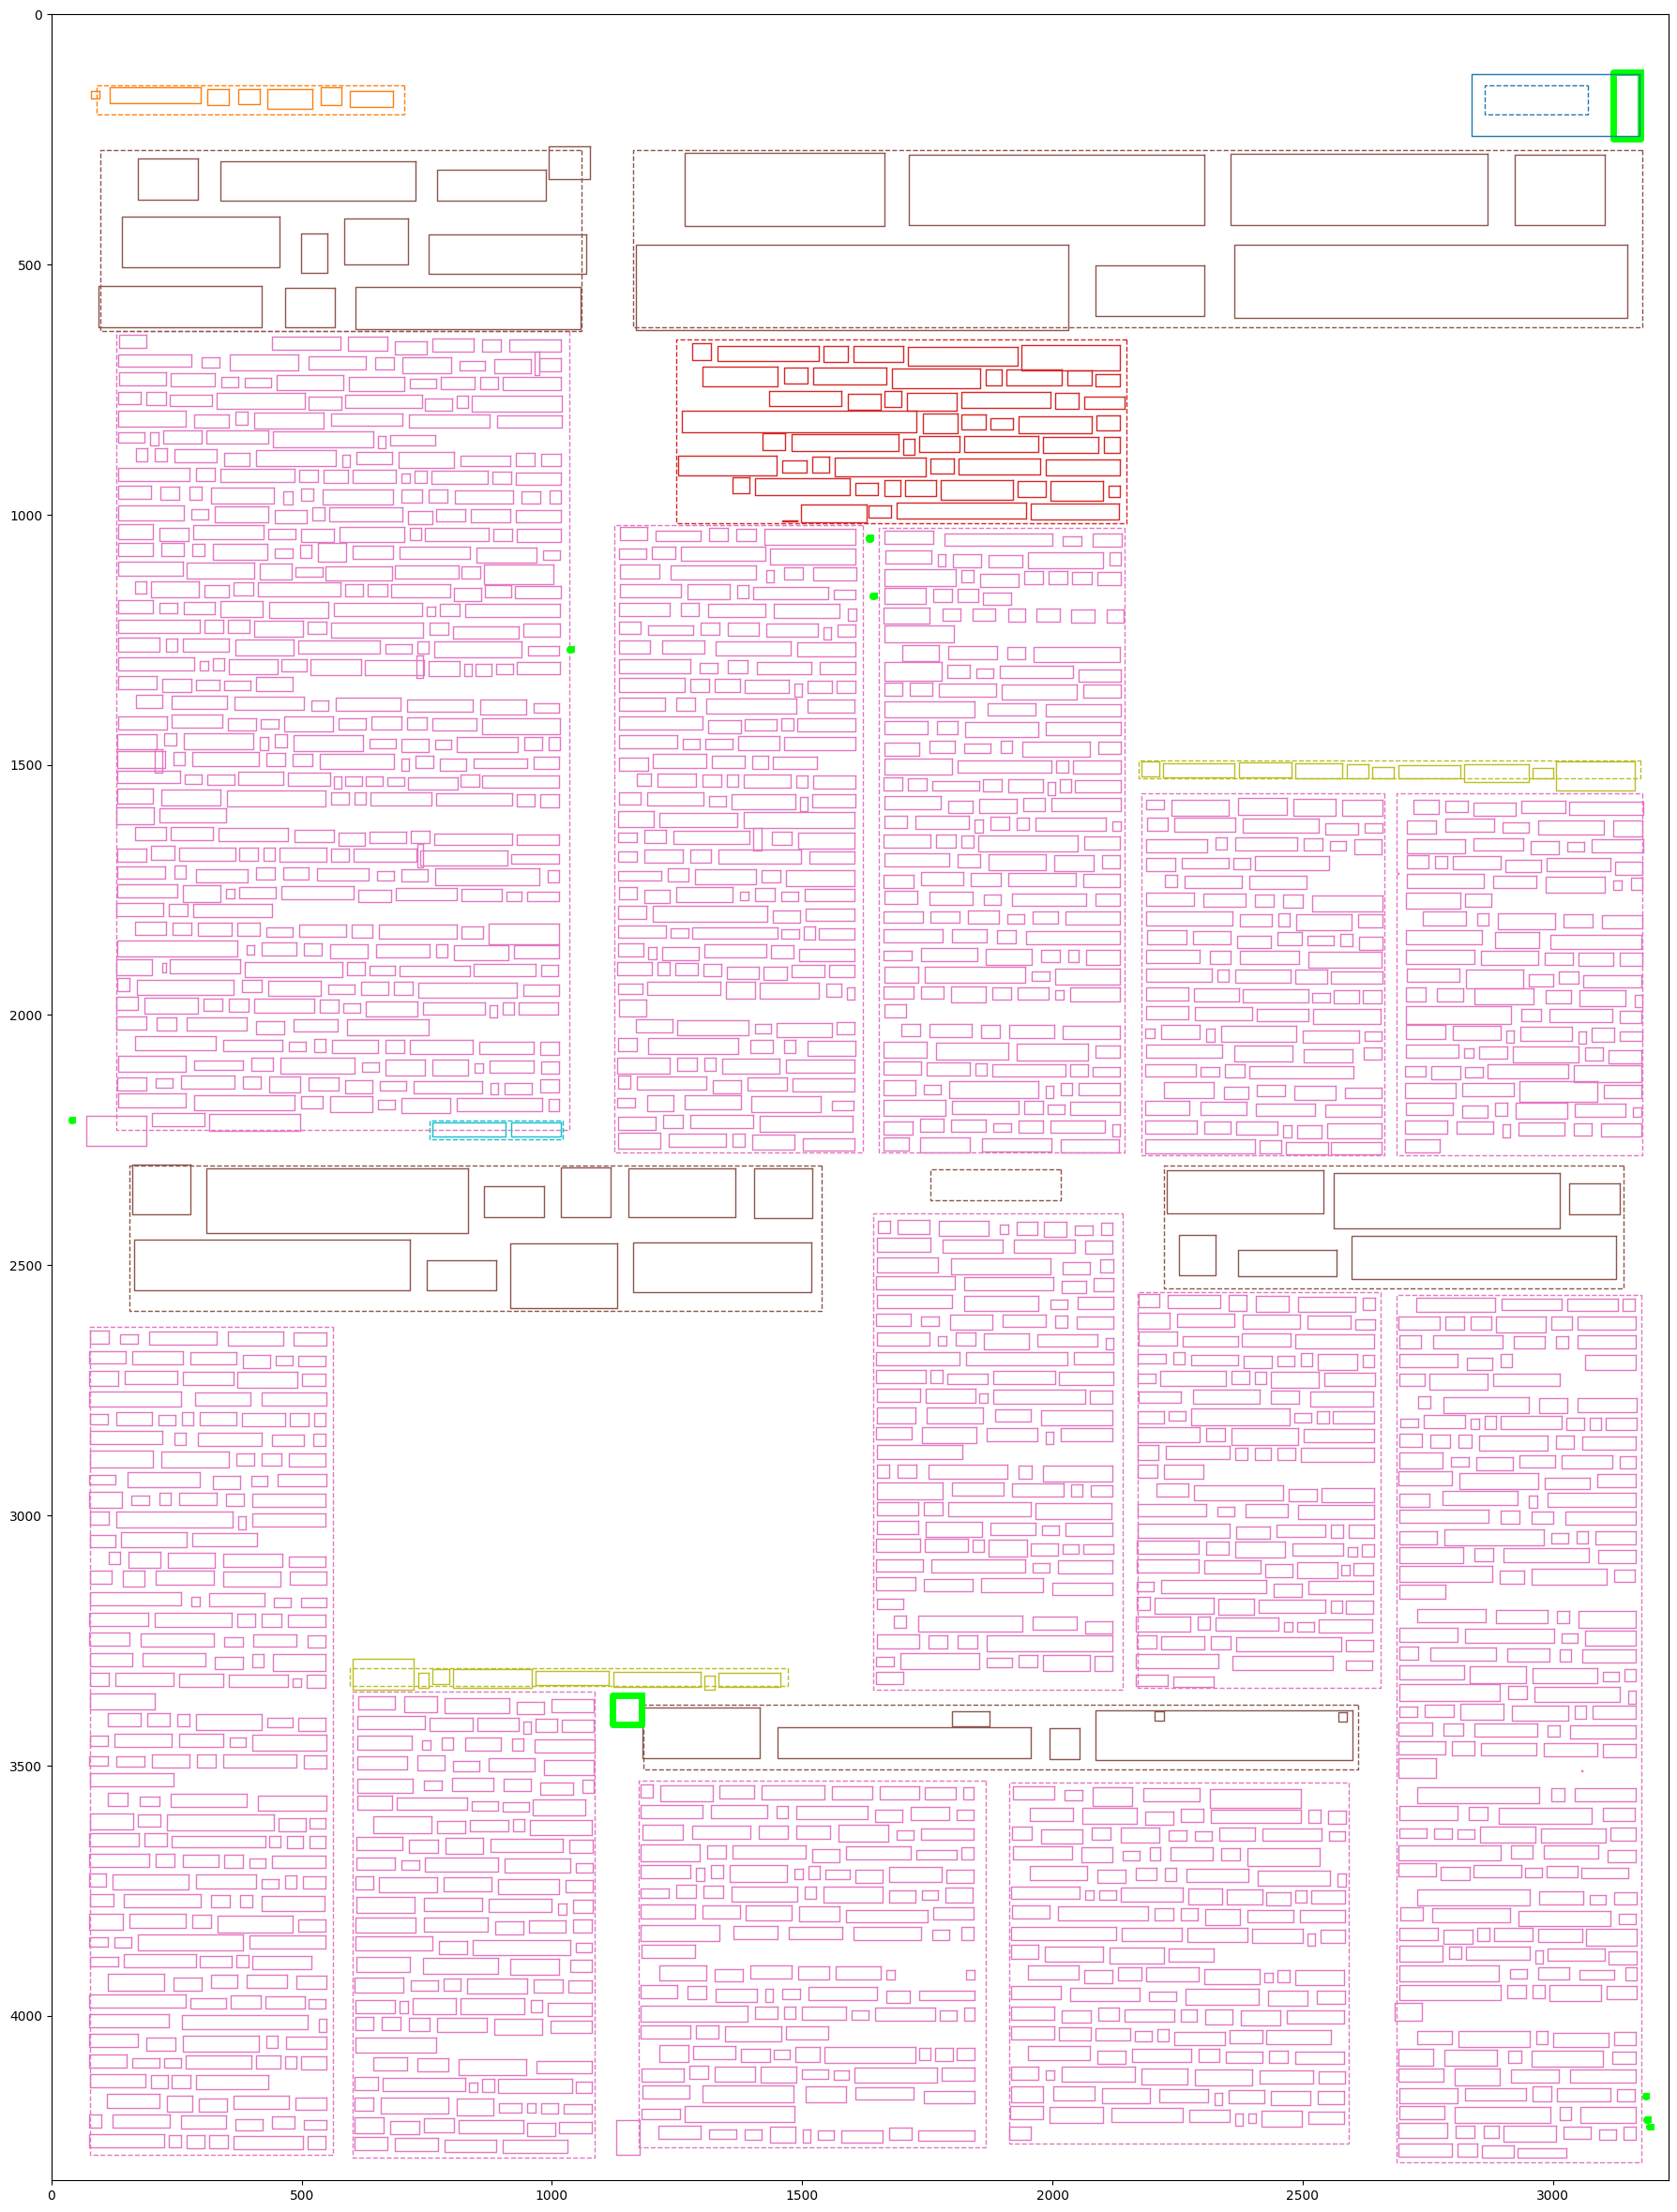

In [155]:
plt.rcParams['figure.figsize'] = [30, 30]
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
for l in df_tokens['label'].value_counts().keys().to_list():
    for r in df_tokens[df_tokens['label']==l]['poligono']:
        linewidth = 1
        if l == -1: linewidth = 5
        r_coords = list(r.exterior.coords)
        ax.plot(*zip(*r_coords), color=color_dict[str(l)], linewidth=linewidth)
        
    for r in segmentos_articulo[segmentos_articulo['label']==l]['poligono']:
        linewidth = 1
        if l == -1: linewidth = 5
        r_coords = list(r.exterior.coords)
        ax.plot(*zip(*r_coords), color=color_dict[str(l)], linewidth=linewidth, linestyle='--')
        
plt.axis([0, articulo['width'], articulo['height'], 0])
plt.savefig("output_debug.jpg")
plt.show()